In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:
def get_name2feat():
    names = np.load('train_filename.npy').tolist()
    feats = np.load('train_feature_ap.npy')
    name2feat={}
    for i,name in enumerate(names):
        name2feat[name]=feats[i]
    return names,name2feat
names,name2feat = get_name2feat()
print len(names)
print len(name2feat.keys())

25888
25882


## 分离大类

In [4]:
all_images = name2feat.keys()

In [43]:
class2set={}
for name in all_images:
    cur = name.strip().split('/')
    cur_label = '/'.join(cur[:3])
    cur_name =  name
    if cur_label not in class2set:
        class2set[cur_label] = []
    class2set[cur_label].append(cur_name)
print 'done'
print 'all %d class' % len(class2set.keys())
cnt = 0
for k in class2set.keys():
    cnt += len(class2set[k])
print 'all %d images'% cnt

done
all 23 class
all 25882 images


## 使用完整名字

In [44]:
sel_cls = np.random.choice(class2set.keys())
print sel_cls
class2set[sel_cls][:4]

img/MEN/Pants


['img/MEN/Pants/id_00006693/01_1_front.jpg',
 'img/MEN/Pants/id_00006826/03_1_front.jpg',
 'img/MEN/Pants/id_00000482/01_1_front.jpg',
 'img/MEN/Pants/id_00003594/07_3_back.jpg']

## 对每个大类进行AP 聚类

In [11]:
from tqdm import tqdm

In [45]:
class_item = sorted(class2set.keys())
class2idx = dict(zip(class_item,xrange(len(class_item))))
clusters = {}
cnt = []
for cls in tqdm(class_item):
    cur_label = class2idx[cls]
    cur_imgs = class2set[cls]
    cur_feats = np.array([name2feat[img] for img in cur_imgs])
    # get cluster idx
    kmeans = AffinityPropagation().fit(cur_feats)
    cur_cnt = len(kmeans.cluster_centers_indices_)
    cnt.append(cur_cnt)
    kmeans_labels = kmeans.labels_
    
    for idx,sub_label in enumerate(kmeans_labels):
        cur_key = str(cur_label)+'_'+str(sub_label)
        if cur_key not in clusters:
            clusters[cur_key] = []
        clusters[cur_key].append(cur_imgs[idx])
print 'clusters.len',sum(cnt)

100%|██████████| 23/23 [02:35<00:00, 18.99s/it]

clusters.len 2087


## save

In [47]:
import cPickle as pickle
with open('ap_cluster_inshop_inclass.pkl','wb') as f:
    pickle.dump(clusters,f)

In [46]:
for idx,cls in enumerate(class_item):
    print len(class2set[cls]),cnt[idx]

206 23
253 24
423 46
298 33
510 62
15 3
248 33
398 53
1244 99
4027 263
684 68
225 25
3451 236
656 62
870 80
205 18
809 79
804 68
1631 144
886 96
1642 125
414 46
5983 401


## 看看聚类效果
- 是否是item 相关呢?
- 只能说差不多。

In [22]:
from PIL import Image

In [48]:
rd = np.random.choice(clusters.keys())
print rd
rd = '22_204'
cls  = int(rd.split('_')[0])
cls = class_item[cls]
print cls
imgs = clusters[rd]
print len(imgs)

13_61
img/WOMEN/Tees_Tanks
4


In [49]:
imgs[:9]

['img/WOMEN/Tees_Tanks/id_00002011/01_4_full.jpg',
 'img/WOMEN/Tees_Tanks/id_00002011/01_7_additional.jpg',
 'img/WOMEN/Tees_Tanks/id_00002011/01_1_front.jpg',
 'img/WOMEN/Tees_Tanks/id_00002011/01_3_back.jpg']

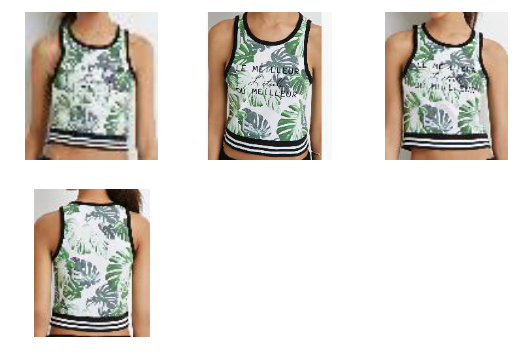

In [51]:
plt.figure(figsize=(9,9))
for i,a in enumerate(imgs[:9]):
    plt.subplot(3,3,i+1)
    im = Image.open('/home/zhangxs/data/In-shop-IR/'+a)
    plt.imshow(im)
    plt.axis('off')

## 保存聚类结果。
- 先测试随机的实验。

In [18]:
np.save('name',np.array(all_images))
np.save('label',labels)
np.save('center_indices',np.array(cluster_centers_indices))

In [ ]:
from itertools import cycle
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    # labels == k 使用k与labels数组中的每个值进行比较
    # 如labels = [1,0],k=0,则‘labels==k’的结果为[False, True]
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]    # 聚类中心的坐标
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

## 计算聚类相似性矩阵

In [33]:
items = sorted(clusters.keys())
print len(items)

2087


In [38]:
def get_mean_feat(cls,imgs):
	shape = name2feat[cls+'/'+imgs[0]].shape
	rst = np.zeros(shape)
	cnt = len(imgs)
	for ap in imgs:
		rst+=name2feat[cls+'/'+ap]
	return rst/cnt

In [39]:
item_mean = {}
for item in items:
    item_int = item.split('_')[0]
    cls = class_item[int(item_int)]
    image_all = clusters[item]
    item_mean[item] = get_mean_feat(cls,image_all)
print len(item_mean.keys())

2087


In [40]:
# 使用相似性
from sklearn.metrics.pairwise import cosine_similarity as cosine
sim_matrix=[]
for item in tqdm(items):
    cur_sim_v = np.array([np.squeeze(cosine(item_mean[item].reshape(1,-1),item_mean[other].reshape(1,-1))) for other in items])
    cur_prob_v = cur_sim_v/np.sum(cur_sim_v)
    sim_matrix.append(cur_prob_v)
np.save('sim_matrix_inshop_ap',np.array(sim_matrix))

100%|██████████| 2087/2087 [09:10<00:00,  4.37it/s]


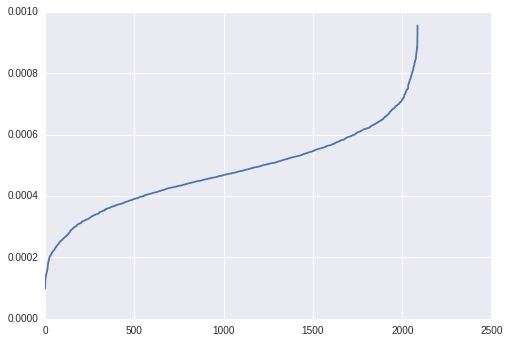

In [41]:
t = np.array(sim_matrix)[0]
plt.plot(sorted(t))